In [1]:
import numpy as np
import csv
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as clrs
import matplotlib.cm as cm
import math
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import re
import collections
import string
from collections import OrderedDict
import random
from collections import Counter
import statistics
num_regex = re.compile(r'\d+')
import os
import operator
import pandas as pd
import string

plt.rcParams["font.family"] = "Times New Roman"
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)

## This notebook is used to plot the genotype distributions for some given runs (the pink and blue plots)

In [2]:
nRuns = 100
runID_offsets = [0, 100]
duration = 4368 #duration of sims in hours - equivalent to 26 weeks
dates = ["24-Sep-2020", "09-Oct-2020", "14-Oct-2020", "06-Nov-2020", "16-Nov-2020", "25-Nov-2020"] #dates the simulations were performed on
pc_res = [14, 15, 16] #percentages of the populations which are resistant to the applied biocide
phase2_str = "phase2"

#parameters for the log normal distributions used
#[scale, sigma]
log_norm_params_14pcRes = [2.703747953786337, 0.5690825284230452]
log_norm_params_15pcRes = [2.6133256846855746, 0.6260058161550592]
log_norm_params_16pcRes = [2.47772924764521, 0.7060073500033884]

In [3]:
def getFilepathToGenoRuns(date, pc_res, phase, suffix=""):
    '''
    creates a string with the file location of the genotype distributions (all the run_ID files)
    
    the suffix argument is used for any extra info in the filename
    '''
    
    return "geno_distb_data_"+phase+"/"+str(pc_res)+"_resistant-"+date+suffix


def getEventCountersDataframe(date, pc_res, phase, sigma, duration, suffix=""):
    
    df = pd.read_csv("geno_distb_data_"+phase+"/"+str(pc_res)+"_resistant-"+date+suffix+"/"+str(pc_res)+"_resistant-"+date+suffix+"-event_counters-sigma="+"{:.5f}".format(sigma)+"-t="+str(duration)+".0.csv")
    df['date'] = date
    return df


def getListOfMeasurementTimes(directory_name):
    '''
    for each runID directory, this gets the filenames and extracts a list of the times they were sampled at.
    directory_name is of form path_to_files/runID_<n>
    
    returns: sorted list of the time vals, in string form with 2 decimal places
    '''
    time_list = []
    def get_numbers_from_filename(filename):
        return re.search(r'(\d+(?:\.\d+)?)', filename).group(0)
    
    for filename in os.listdir(directory_name):
        time_list.append(float(get_numbers_from_filename(filename)))

    return ["{:.2f}".format(float(t)) for t in sorted(time_list)]

In [4]:
# #due to different sessions having different numbers of runs, we'll use the 
# event_counters_14pc_24Sep = getEventCountersDataframe(dates[0], pc_res[0], phase2_str, log_norm_params_14pcRes[1], duration)
# event_counters_15pc_24Sep = getEventCountersDataframe(dates[0], pc_res[1], phase2_str, log_norm_params_15pcRes[1], duration)
# event_counters_16pc_24Sep = getEventCountersDataframe(dates[0], pc_res[2], phase2_str, log_norm_params_16pcRes[1], duration)

# event_counters_14pc_09Oct = getEventCountersDataframe(dates[1], pc_res[0], phase2_str, log_norm_params_14pcRes[1], duration)
# event_counters_15pc_09Oct = getEventCountersDataframe(dates[1], pc_res[1], phase2_str, log_norm_params_15pcRes[1], duration)
# event_counters_16pc_09Oct = getEventCountersDataframe(dates[1], pc_res[2], phase2_str, log_norm_params_16pcRes[1], duration)

# event_counters_14pc_14Oct = getEventCountersDataframe(dates[2], pc_res[0], phase2_str, log_norm_params_14pcRes[1], duration)
# event_counters_15pc_14Oct = getEventCountersDataframe(dates[2], pc_res[1], phase2_str, log_norm_params_15pcRes[1], duration)
# event_counters_16pc_14Oct = getEventCountersDataframe(dates[2], pc_res[2], phase2_str, log_norm_params_16pcRes[1], duration)

# event_counters_14pc_06Nov = getEventCountersDataframe(dates[3], pc_res[0], phase2_str, log_norm_params_14pcRes[1], duration)
# event_counters_15pc_06Nov = getEventCountersDataframe(dates[3], pc_res[1], phase2_str, log_norm_params_15pcRes[1], duration)
# event_counters_16pc_06Nov = getEventCountersDataframe(dates[3], pc_res[2], phase2_str, log_norm_params_16pcRes[1], duration)

# event_counters_14pc_16Nov = getEventCountersDataframe(dates[4], pc_res[0], phase2_str, log_norm_params_14pcRes[1], duration)
# event_counters_15pc_16Nov = getEventCountersDataframe(dates[4], pc_res[1], phase2_str, log_norm_params_15pcRes[1], duration)
# event_counters_16pc_16Nov = getEventCountersDataframe(dates[4], pc_res[2], phase2_str, log_norm_params_16pcRes[1], duration)

# event_counters_14pc_25Nov = getEventCountersDataframe(dates[5], pc_res[0], phase2_str, log_norm_params_14pcRes[1], duration)
# event_counters_15pc_25Nov = getEventCountersDataframe(dates[5], pc_res[1], phase2_str, log_norm_params_15pcRes[1], duration)
# event_counters_16pc_25Nov = getEventCountersDataframe(dates[5], pc_res[2], phase2_str, log_norm_params_16pcRes[1], duration)




# these are for the simulations where migration rate was changed 1 -> 0.1
event_counters_16pc_05_Jan_low_r_mig = getEventCountersDataframe( "5-Jan-2022", pc_res[2], phase2_str, log_norm_params_16pcRes[1], duration, suffix="-migration_rate-0.1")
event_counters_16pc_10_Jan_low_r_mig = getEventCountersDataframe("10-Jan-2022", pc_res[2], phase2_str, log_norm_params_16pcRes[1], duration, suffix="-migration_rate-0.1")
event_counters_16pc_11_Jan_low_r_mig = getEventCountersDataframe("11-Jan-2022", pc_res[2], phase2_str, log_norm_params_16pcRes[1], duration, suffix="-migration_rate-0.1")
event_counters_16pc_14_Jan_low_r_mig = getEventCountersDataframe("14-Jan-2022", pc_res[2], phase2_str, log_norm_params_16pcRes[1], duration, suffix="-migration_rate-0.1")

all_event_counters_16pc_low_r_mig = pd.concat([event_counters_16pc_05_Jan_low_r_mig, event_counters_16pc_10_Jan_low_r_mig, event_counters_16pc_11_Jan_low_r_mig, 
                                               event_counters_16pc_14_Jan_low_r_mig], ignore_index=True)


print('n_biofilm: ',len((all_event_counters_16pc_low_r_mig[all_event_counters_16pc_low_r_mig["bf_thickness"] > 0].sort_values(by=["n_replications"], ascending=False)['runID'])))
print('total_runs: ',len(all_event_counters_16pc_low_r_mig['runID']))

n_biofilm:  63
total_runs:  400


In [5]:
# get all the old (higher migration rate) 16% results to improve accuracy of biofilm formation stats.  We only care about ones which established biofilm, which
# doesn't rely on migration rate.
event_counters_16pc_24Sep = getEventCountersDataframe(dates[0], pc_res[2], phase2_str, log_norm_params_16pcRes[1], duration)
event_counters_16pc_09Oct = getEventCountersDataframe(dates[1], pc_res[2], phase2_str, log_norm_params_16pcRes[1], duration)
event_counters_16pc_14Oct = getEventCountersDataframe(dates[2], pc_res[2], phase2_str, log_norm_params_16pcRes[1], duration)
event_counters_16pc_06Nov = getEventCountersDataframe(dates[3], pc_res[2], phase2_str, log_norm_params_16pcRes[1], duration)
event_counters_16pc_16Nov = getEventCountersDataframe(dates[4], pc_res[2], phase2_str, log_norm_params_16pcRes[1], duration)
event_counters_16pc_25Nov = getEventCountersDataframe(dates[5], pc_res[2], phase2_str, log_norm_params_16pcRes[1], duration)

all_event_counters_16pc = pd.concat([event_counters_16pc_24Sep, event_counters_16pc_09Oct, event_counters_16pc_14Oct, event_counters_16pc_06Nov,
                                     event_counters_16pc_16Nov, event_counters_16pc_25Nov], ignore_index=True)

print('n_biofilm: ',len((all_event_counters_16pc[all_event_counters_16pc["bf_thickness"] > 0].sort_values(by=["n_replications"], ascending=False)['runID'])))
print('total_runs: ',len(all_event_counters_16pc['runID']))

print('\nall 16%')
print('n_biofilm: ',(37+63))
print('total_runs: ',(400+225))
print((37+63)/(400+225))

n_biofilm:  37
total_runs:  225

all 16%
n_biofilm:  100
total_runs:  625
0.16


In [6]:
# all_event_counters_14pc = pd.concat([event_counters_14pc_24Sep, event_counters_14pc_09Oct, event_counters_14pc_14Oct, event_counters_14pc_06Nov, 
#                                      event_counters_14pc_16Nov, event_counters_14pc_25Nov], ignore_index=True)

# all_event_counters_15pc = pd.concat([event_counters_15pc_24Sep, event_counters_15pc_09Oct, event_counters_15pc_14Oct, event_counters_15pc_06Nov,
#                                      event_counters_15pc_16Nov, event_counters_15pc_25Nov], ignore_index=True)

# all_event_counters_16pc = pd.concat([event_counters_16pc_24Sep, event_counters_16pc_09Oct, event_counters_16pc_14Oct, event_counters_16pc_06Nov,
#                                      event_counters_16pc_16Nov, event_counters_16pc_25Nov], ignore_index=True)
#all_event_counters_14pc[all_event_counters_14pc["bf_thickness"] > 0]
#print((all_event_counters_14pc[all_event_counters_14pc["runID"]==198]["date"].values[0]))


#(all_event_counters_16pc[all_event_counters_16pc["bf_thickness"] > 0].sort_values(by=["n_replications"], ascending=False))
(all_event_counters_16pc_low_r_mig[all_event_counters_16pc_low_r_mig["bf_thickness"] > 0].sort_values(by=["n_replications"], ascending=False))

,runID,bf_thickness,exit_time,final_pop,avg_pop,n_deaths,n_detachments,n_immigrations,n_migrations,n_replications,date
103,103,40,4123,16736,4208,349501,23652,82402,0,307482,10-Jan-2022
348,348,40,3956,16628,4347,347003,23121,79276,0,307471,14-Jan-2022
363,363,40,3884,16817,4364,345082,22514,77423,0,306985,14-Jan-2022
379,379,40,2656,16588,6269,327352,15118,53041,0,306012,14-Jan-2022
276,276,40,3207,16788,5306,334566,18329,63957,0,305721,11-Jan-2022
...,...,...,...,...,...,...,...,...,...,...,...
39,39,2,4368,751,362,73475,26677,87134,0,13764,5-Jan-2022
206,206,1,4368,682,347,72531,26849,87470,0,12587,11-Jan-2022
257,257,1,4368,674,352,72614,26532,87602,0,12213,11-Jan-2022
262,262,1,4368,582,340,71854,26966,87435,0,11962,11-Jan-2022


In [7]:
print(len(all_event_counters_16pc_low_r_mig.index))
print(len(all_event_counters_16pc_low_r_mig[all_event_counters_16pc_low_r_mig["bf_thickness"] > 0].sort_values(by=["n_replications"], ascending=False).index))

400
63


In [8]:
# no of low migration 16% sims which reached thickness limit
n_thick = len(all_event_counters_16pc_low_r_mig[all_event_counters_16pc_low_r_mig["exit_time"] < 4368].sort_values(by=["n_replications"], ascending=False).index)
total_growth = len(all_event_counters_16pc_low_r_mig[all_event_counters_16pc_low_r_mig["bf_thickness"] > 0].sort_values(by=["n_replications"], ascending=False).index)

print(n_thick)
print(total_growth)

print(str(n_thick/total_growth*100)+"%\n")


# n_thick = len(event_counters_16pc_05_Jan_low_r_mig[event_counters_16pc_05_Jan_low_r_mig["exit_time"] < 4368].sort_values(by=["n_replications"], ascending=False).index)
# total_growth = len(event_counters_16pc_05_Jan_low_r_mig[event_counters_16pc_05_Jan_low_r_mig["bf_thickness"] > 0].sort_values(by=["n_replications"], ascending=False).index)

# print(n_thick)
# print(total_growth)

# print(str(n_thick/total_growth*100)+"%")

38
63
60.317460317460316%



In [9]:
def getGenoDistbDict(runID, pc_res, phase_val, event_counters, suffix=""):
    '''
    gets a dict containing the geno distbs over time.
    each key is the time step.
    each entry is a dataframe containing the genotypes in each microhabitat
    '''
    
    runID_key = "runID_"+str(runID)
    #due to the varying no. of runs in each session, (depending on % resistant) we'll use the counters dataframe to get the date
    date = event_counters[event_counters["runID"]==runID]["date"].values[0]

    
    directoryPath = getFilepathToGenoRuns(date=date, pc_res=pc_res, phase=phase_val, suffix=suffix)
    filepath_runID = directoryPath+"/"+runID_key
    
    geno_time_dict = {} #dictionary containing geno dataframes for each timestep
    time_list = getListOfMeasurementTimes(filepath_runID) #sorted list of the times that the genos were sampled at in this run
    
    for t in time_list:
            
        filepath_time = filepath_runID+"/geno_distb-t="+t+".csv"

        #need to swap the rows and columns so that the microhabitat is the key in the dataframe
        geno_df = pd.DataFrame([line.strip().split(',') for line in open(filepath_time, 'r')]).T
        new_header = geno_df.iloc[0] #grab the first row for the header
        geno_df = geno_df[1:] #take the data less the header row
        geno_df.columns = new_header #set the header row as the df header

        geno_df = geno_df.astype(float)

        #round the time to the nearest integer value to make reading it in easier
        #the [-3] is so the decimal point and decimal numbers are removed when casting the string to an int
        geno_time_dict[int(t[:-3])] = geno_df
    
    return geno_time_dict

In [10]:
def plotGenoDistbsInSystemOverTime_WRT_t(geno_dict, runID, pc_res, event_counters):
    '''
    This is the method that makes the big blue and pink plots, showing the distribution of genotypes over time throughout the system
    Input is the geno_dict, where each key is the timestep and each entry is a dataframe where each column is the genotypes in each microhabitat
    
    This plots the size of the pop distb and the various genotypes as a function of N. (height of bars not normalised currently)
    
    NB: it might be better to normalise the geno plots for the vs N ones, but not normalise the ones vs t
    '''
    
    #make a new dict where each key is the timestep, each entry is the dataframe values condensed into a single array (2D dataframe -> 1D array)
    collated_geno_dict = {}
    n_dict = {} #this will save the pop size N at time t (bit overengineered, this is kinda shoehorned in to plot vs N instead of t)
    min_geno_val = 9e9
    max_geno_val = 0. #this will be updated to be the genotype of the most resistant bacteria in the system, used for scaling the colourmap
    
    for t in geno_dict.keys():
        #gets all the genotypes from the dataframe, removes NaNs and converts to 1D numpy array
        #round the genotypes to n decimal places
        processed_genos = np.around(geno_dict[t].values[~np.isnan(geno_dict[t].values)].flatten(), decimals=0)
        max_geno_val = max(np.max(processed_genos), max_geno_val)
        min_geno_val = min(np.min(processed_genos), min_geno_val)
        #dict containing the species genotypes (keys) and no. of ocurrences of each (values)
        geno_counts = Counter(processed_genos)
        n_bac = sum(geno_counts.values())
        #sort the geno counts so they're arranged in order of increasing resistance
        #geno_counts = dict(sorted(geno_counts.items()))
        geno_counts = dict(geno_counts.items())
        
        '''this for loop is the bit where the height normalisation happens'''
#         for key in geno_counts:
#             geno_counts[key] = geno_counts[key]/n_bac
        #divide the counts by the total no. of bacteria
#         normalised_geno_counts = {k: v/n_bac for k, v in geno_counts}
        
        collated_geno_dict[t] = geno_counts
        n_dict[t] = n_bac
        
    
    fig, ax = plt.subplots()
    fig.set_size_inches(9, 6.2)
    titleSize = 16
    labelSize = 16
    numbersize = 12
    legendsize = 10
    IDsize=12

    colour_list = []
    t_last = 0
    t_list = list(collated_geno_dict.keys())
    delta_t = (t_list[1] - t_list[0]) + 1.
    for t in collated_geno_dict.keys():
        bar_ypos = 0 #used to adjust the bottom of the bar chart so we can stack bacteria on top of one another
        #print(t)
        for geno_val in collated_geno_dict[t].keys():
            #print(geno_val)
            percent_of_max_r = geno_val/max_geno_val #how resistant is this genotype compared to the most resistant one
            #geno_colour = (percent_of_max_r, 0.3*percent_of_max_r, 0.42) #colour representing the genotype's resistance
            #colour_list.append(geno_colour)
            geno_colour2 = cm.magma(percent_of_max_r)
            
            bars = ax.bar(x = t, height=collated_geno_dict[t][geno_val], bottom=bar_ypos, color=geno_colour2, width=delta_t, label=geno_val)
            bar_ypos += collated_geno_dict[t][geno_val]
        
        t_last = float(t)
        n_last = float(n_dict[t])

    
    cmap_string = "magma"
    sm = plt.cm.ScalarMappable(cmap=cmap_string)
    sm.set_array([])
    n_ticks = 6

    cbar = fig.colorbar(sm)
    cbar.ax.locator_params(nbins=n_ticks)
    ctick_labels = ["{:.1f}".format(x) for x in list(np.linspace(min_geno_val, max_geno_val, n_ticks))]
    cbar.ax.set_yticklabels(ctick_labels) 
    cbar.ax.tick_params(labelsize=labelSize)
    cbar.set_label("resistance", fontsize=labelSize)
    
    ax.set_ylabel('$n_i/N$', fontsize=labelSize)
    ax.set_xlabel('t', fontsize=labelSize)
    plt.xticks(fontsize=18)
    plt.locator_params(axis='x', nbins=4)
    plt.yticks(fontsize=18)
    
    #print(event_counters.loc[event_counters['runID']==runID]["bf_thickness"].values)
    plt.title(str(pc_res)+'% resistant,    '+'run: '+str(runID)+'    thickness: '+str(event_counters.loc[event_counters['runID']==runID]["bf_thickness"].values[0])+"$\mu m$", fontsize=titleSize)
    plt.xlim(0, duration)
    #plt.ylim(0, 1)
    
    #plt.savefig('geno_distb_plots/'+str(pc_res)+"pc_res-runID_"+str(runID)+"_vs_t.png")
    plt.show()
    
    
#     fig, ax = plt.subplots()
#     fig.set_size_inches(9, 6.2)
#     titleSize = 16
#     labelSize = 16
#     numbersize = 12
#     legendsize = 10
#     IDsize=12
    
#     #print(list(n_dict.keys()))
#     ax.plot(list(n_dict.keys()), list(n_dict.values()))
#     ax.set_ylabel('$N$', fontsize=labelSize)
#     ax.set_xlabel('t', fontsize=labelSize)
#     plt.xticks(fontsize=18)
#     plt.locator_params(axis='x', nbins=4)
#     plt.yticks(fontsize=18)
    
#     #print(event_counters.loc[event_counters['runID']==runID]["bf_thickness"].values)
#     plt.title(str(pc_res)+'% resistant,    '+'run: '+str(runID)+'    thickness: '+str(event_counters.loc[event_counters['runID']==runID]["bf_thickness"].values[0])+"$\mu m$", fontsize=titleSize)
    
    
    #plt.show()

In [11]:
runID = 96
# for runID in list(all_event_counters_16pc_low_r_mig[all_event_counters_16pc_low_r_mig["bf_thickness"] > 0].sort_values(by=["n_replications"], ascending=False)["runID"].values):
#     x = getGenoDistbDict(runID, 16, phase2_str, all_event_counters_16pc_low_r_mig, suffix='-migration_rate-0.1')
#     plotGenoDistbsInSystemOverTime_WRT_t(x, runID=runID, pc_res=16, event_counters=all_event_counters_16pc_low_r_mig)
# plotGenoDistbsInSystemOverTime_WRT_t(x, runID=184, pc_res=14, event_counters=all_event_counters_14pc)

In [12]:
def getN_maxAndGeno_max(geno_data_list):
    '''
    Takes in a list of geno data dicts and returns the values of the most resistant bug and the largest pop size in them.
    This is used for calibrating the y-axis and colour bar for when we have several geno plots.
    '''
    
    n_max = 0.
    geno_max = 0.
    
    for geno_dict in geno_data_list:
        for t in geno_dict.keys():
            #gets all the genotypes from the dataframe, removes NaNs and converts to 1D numpy array
            #round the genotypes to n decimal places
            processed_genos = np.around(geno_dict[t].values[~np.isnan(geno_dict[t].values)].flatten(), decimals=0)
            geno_max = max(np.max(processed_genos), geno_max)


            geno_counts = Counter(processed_genos)
            n_max = max(sum(geno_counts.values()), n_max)
        
    
    return n_max, geno_max


def getNewMicrohabTimes(geno_dict):
    '''
    Iterates through the geno dict.  Each dict entry is a dataframe where the columns are the genotypes in each microhabitat.
    
    returns a list of times (geno dict keys) at which new microhabitats are added.
    
    this assumes the dictionary keys are sorted chronologically
    '''
    
    new_mh_times = [] # list of new microhab times
    n_mh = 0 # no. of microhabs
    
    for time, geno_df in geno_dict.items():
        
        if len(geno_df.columns) > n_mh:
            n_mh = len(geno_df.columns)
            new_mh_times.append(time/(24.*7.)) # convert to weeks
            
    return sorted(new_mh_times)

In [13]:
# pcres_14_run_a = getGenoDistbDict(17,  14, phase2_str, all_event_counters_14pc)
# pcres_14_run_b = getGenoDistbDict(326, 14, phase2_str, all_event_counters_14pc) # was 17
# pcres_14_run_c = getGenoDistbDict(707, 14, phase2_str, all_event_counters_14pc)
# pcres_14_run_d = getGenoDistbDict(351, 14, phase2_str, all_event_counters_14pc)
# geno_2x2_plot_data = [pcres_14_run_a, pcres_14_run_b, pcres_14_run_c, pcres_14_run_d]
# n_max_2x2, geno_max_2x2 = getN_maxAndGeno_max(geno_2x2_plot_data)

# geno_2x3_plot_data = [pcres_14_run_a, pcres_14_run_c, pcres_14_run_d] # used for the newer 2x3 plots

# these are used for comparing the migration rates
# regular migration rate
# pcres_16_run_a = getGenoDistbDict(115, 16, phase2_str, all_event_counters_16pc)
# pcres_16_run_b = getGenoDistbDict(0,   16, phase2_str, all_event_counters_16pc)
# pcres_16_run_c = getGenoDistbDict(81,  16, phase2_str, all_event_counters_16pc)
# geno_2x3_plot_data_regular_r_mig = [pcres_16_run_a, pcres_16_run_b, pcres_16_run_c]
# n_max_2x3_16pc, geno_max_2x3_16pc = getN_maxAndGeno_max(geno_2x3_plot_data_regular_r_mig)

# low migration rate
pcres_16_run_a_low_r_mig = getGenoDistbDict(25, 16, phase2_str, all_event_counters_16pc_low_r_mig, suffix="-migration_rate-0.1")
pcres_16_run_b_low_r_mig = getGenoDistbDict(87, 16, phase2_str, all_event_counters_16pc_low_r_mig, suffix="-migration_rate-0.1")
pcres_16_run_c_low_r_mig = getGenoDistbDict(96, 16, phase2_str, all_event_counters_16pc_low_r_mig, suffix="-migration_rate-0.1")
pcres_16_run_d_low_r_mig = getGenoDistbDict(40, 16, phase2_str, all_event_counters_16pc_low_r_mig, suffix="-migration_rate-0.1") # used for 1x3 plot
geno_plot_data_low_r_mig = [pcres_16_run_a_low_r_mig, pcres_16_run_b_low_r_mig, pcres_16_run_c_low_r_mig, pcres_16_run_d_low_r_mig]
geno_2x3_plot_data_low_r_mig = geno_plot_data_low_r_mig[0:-1]
n_max_2x3_16pc_low_r_mig, geno_max_2x3_16pc_low_r_mig = getN_maxAndGeno_max(geno_2x3_plot_data_low_r_mig)

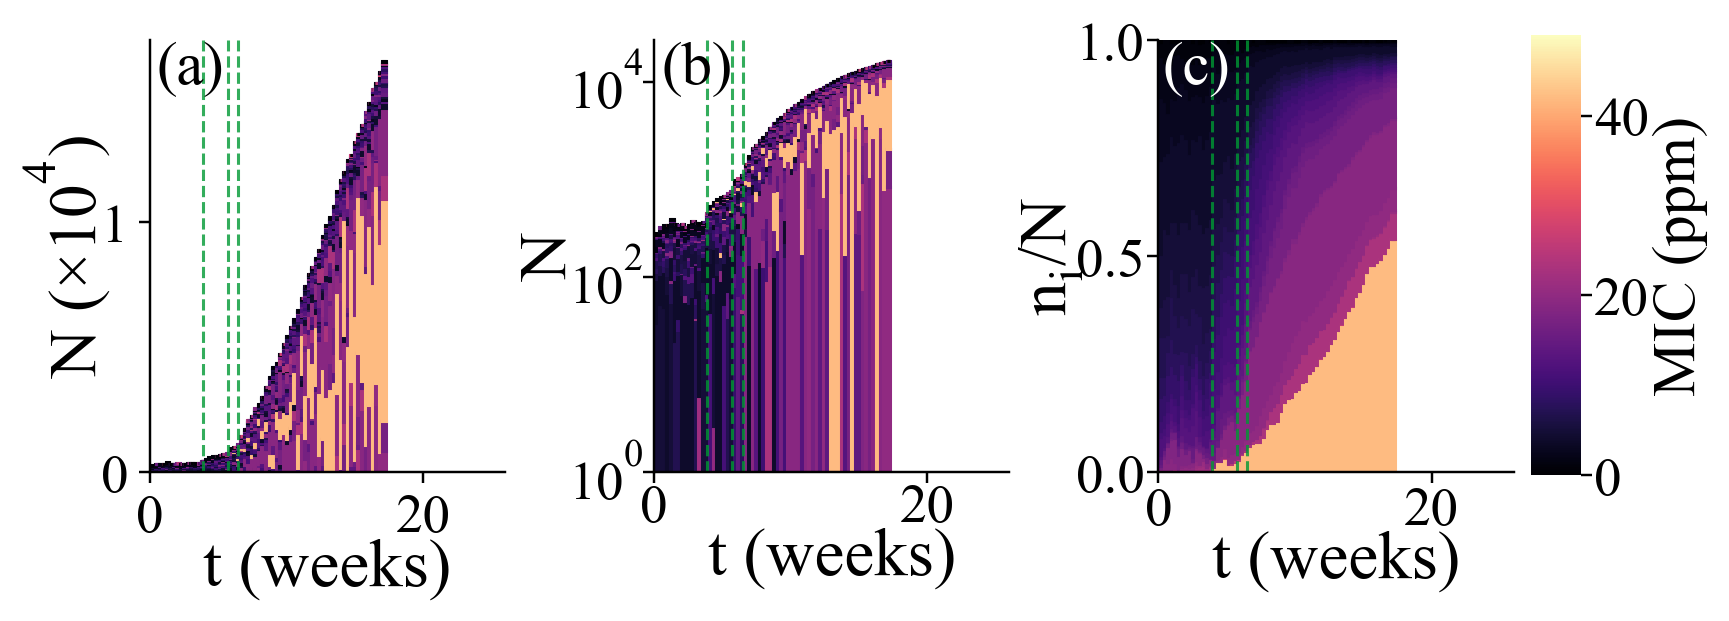

In [23]:
def plot1x3GridOfGenoDistbs_wrt_t(geno_data, N_max, geno_max):
    '''
    Plots a 1x3 grid of the different plots for a given genotype
    Do a regular N vs t, N vs t (log scale) and N normalised.
    '''
    
    fig, axes = plt.subplots(1, 3, dpi=220, sharex=True)
    plt.subplots_adjust(wspace=0.42)
    fig.set_size_inches(8,2.6)
    titleSize = 16
    labelSize = 13.8
    numbersize = 18
    legendsize = 10
    IDsize=12
    
    y_label_list = ["N ($\\times 10^4$)", "N", "n$_i$/N"]
    letters = list(string.ascii_lowercase)[:3]
    new_mh_times = getNewMicrohabTimes(geno_data)
    
    for ax, letter, y_label in zip(axes.flat[:2], letters, y_label_list):
        
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        #make a new dict where each key is the timestep, each entry is the dataframe values condensed into a single array (2D dataframe -> 1D array)
        collated_geno_dict = {}
        n_dict = {} #this will save the pop size N at time t (bit overengineered, this is kinda shoehorned in to plot vs N instead of t)

        for t in geno_data.keys():
            #gets all the genotypes from the dataframe, removes NaNs and converts to 1D numpy array
            #round the genotypes to n decimal places
            processed_genos = np.around(geno_data[t].values[~np.isnan(geno_data[t].values)].flatten(), decimals=0)

            #dict containing the species genotypes (keys) and no. of ocurrences of each (values)
            geno_counts = Counter(processed_genos)
            n_bac = sum(geno_counts.values())
            #sort the geno counts so they're arranged in order of increasing resistance - REMOVED
            geno_counts = dict((geno_counts.items()))

            collated_geno_dict[t] = geno_counts
            n_dict[t] = n_bac


        colour_list = []
        t_last = 0
        t_list = list(collated_geno_dict.keys())
        t_list = [t/(24.*7.) for t in t_list] # rescale to weeks
        delta_t = (t_list[1] - t_list[0]) + 1./(24*7.)
        
        for t_scaled, t in zip(t_list, collated_geno_dict.keys()):
            bar_ypos = 0 #used to adjust the bottom of the bar chart so we can stack bacteria on top of one another
            for geno_val in collated_geno_dict[t].keys():
                percent_of_max_r = geno_val/geno_max #how resistant is this genotype compared to the most resistant one
                geno_colour2 = cm.magma(percent_of_max_r)

                bars = ax.bar(x = t_scaled, height=collated_geno_dict[t][geno_val], bottom=bar_ypos, color=geno_colour2, width=delta_t, label=geno_val, edgecolor=geno_colour2, linewidth=1)
                bar_ypos += collated_geno_dict[t][geno_val]

            t_last = float(t)
            n_last = float(n_dict[t])
        
        for nmh_t in new_mh_times[1:4]:
            ax.axvline(nmh_t, ls="--", c='#009933', lw=1., alpha=0.8)
        
        duration_weeks = duration/(24.*7) # rescale to weeks
        
        ax.set_xlim(0, duration_weeks)
        ax.text(0.02, 0.9, "("+letter+")", transform=ax.transAxes, fontsize=20)
        ax.set_xlabel("t (weeks)", fontsize=22, labelpad=-2)
        ax.set_ylabel(y_label, fontsize=22, labelpad=-4)
        ax.tick_params(axis='both', labelsize=numbersize)
        
        if letter == "a": ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
        elif letter == "b": 
            ax.semilogy()
            ax.tick_params(axis='both', labelsize=numbersize, pad=0)
        
        ax.yaxis.get_offset_text().set_visible(False)
        
        
    # now do the normalised one
    for ax, letter, y_label in zip(axes.flat[2:], letters[2:], y_label_list[2:]):

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
                
        #make a new dict where each key is the timestep, each entry is the dataframe values condensed into a single array (2D dataframe -> 1D array)
        collated_geno_dict = {}
        n_dict = {} #this will save the pop size N at time t (bit overengineered, this is kinda shoehorned in to plot vs N instead of t)
        min_geno_val = 9e9
        max_geno_val = 0. #this will be updated to be the genotype of the most resistant bacteria in the system, used for scaling the colourmap
        for t in geno_data.keys():
            #gets all the genotypes from the dataframe, removes NaNs and converts to 1D numpy array
            #round the genotypes to n decimal places
            processed_genos = np.around(geno_data[t].values[~np.isnan(geno_data[t].values)].flatten(), decimals=0)
            #dict containing the species genotypes (keys) and no. of ocurrences of each (values)
            geno_counts = Counter(processed_genos)
            n_bac = sum(geno_counts.values())
            #sort the geno counts so they're arranged in order of increasing resistance
            geno_counts = dict(sorted(geno_counts.items(), reverse=True))

            '''this for loop is the bit where the height normalisation happens'''
            for key in geno_counts:
                geno_counts[key] = geno_counts[key]/n_bac
            #divide the counts by the total no. of bacteria
            collated_geno_dict[t] = geno_counts
            n_dict[t] = n_bac


        colour_list = []
        t_last = 0
        n_old = 0 #used for getting the width of the bars
        t_list = list(collated_geno_dict.keys())
        t_list = [t/(24.*7.) for t in t_list] # rescale to weeks
        delta_t = (t_list[1] - t_list[0]) + 1./(24*7.)
        
        for t_scaled, t in zip(t_list, collated_geno_dict.keys()):
            bar_ypos = 0 #used to adjust the bottom of the bar chart so we can stack bacteria on top of one another
            for geno_val in collated_geno_dict[t].keys():
                #print(geno_val)
                percent_of_max_r = geno_val/geno_max #how resistant is this genotype compared to the most resistant one
                geno_colour2 = cm.magma(percent_of_max_r)

                # add the edgecolour to get rid of the pdf aliasing-type effects
                bars = ax.bar(x = t_scaled, height=collated_geno_dict[t][geno_val], bottom=bar_ypos, color=geno_colour2, width=delta_t, label=geno_val, edgecolor=geno_colour2, linewidth=1)
                bar_ypos += collated_geno_dict[t][geno_val]

            n_old = n_dict[t]
            t_last = float(t)
            n_last = float(n_dict[t])
            
            
        for nmh_t in new_mh_times[1:4]:
            ax.axvline(nmh_t, ls="--", c='#009933', lw=1., alpha=0.8)
            
        ax.set_ylim(0, 1.)
        ax.set_ylabel(y_label, fontsize=22, labelpad=-3)
        ax.set_xlabel("t (weeks)", fontsize=22, labelpad=-2)
        ax.set_yticks([0., 0.5, 1.0])
        ax.set_xlim(0, duration/(24.*7))
        ax.text(0.01, 0.9, "("+letter+")", transform=ax.transAxes, fontsize=20, color='white')
        ax.tick_params(axis='both', labelsize=numbersize, pad=1)
        
        
    cmap = plt.get_cmap('magma') # make sure this matches the one used above
    cbar_ax = fig.add_axes([0.91, 0.12, 0.028, 0.77])
    cbar = fig.colorbar(cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=geno_max), cmap=cmap), cax=cbar_ax)
    cbar.set_label(f'MIC (ppm)', fontsize=20, labelpad=1)
    cbar.ax.tick_params(labelsize=numbersize, pad=1)
    cbar.outline.set_visible(False)
        


#     plt.savefig('geno_distb_plots/1x3_plot_showcase_vs_t.pdf', bbox_inches="tight", dpi=330)
    plt.savefig('ms_paper_plots/1x3_plot_showcase_vs_t_low_migration.pdf', bbox_inches="tight", dpi=330)
    plt.show()
    
    
#plot1x3GridOfGenoDistbs_wrt_t(pcres_14_run_b, N_max=n_max_2x2, geno_max=geno_max_2x2)
plot1x3GridOfGenoDistbs_wrt_t(pcres_16_run_d_low_r_mig, N_max=n_max_2x3_16pc_low_r_mig, geno_max=geno_max_2x3_16pc_low_r_mig)

In [24]:
def plot2x3GridOfGenoDistbs_wrt_t(geno_data_list, N_max, geno_max, log_scale=False):
    '''
    Plots a 2x3 grid of the remaining plots from the original 2x2 plots
    
    (a-c) do regular geno distbs (probably log scale)
    (d-f) corresponding normalised population fraction ones.
    
    '''
    
    fig, axes = plt.subplots(2, 3, dpi=220, sharex=True, sharey="row")
    plt.subplots_adjust(wspace=0.08, hspace=0.12)
    fig.set_size_inches(8,4.2)
    titleSize = 16
    labelSize = 13.8
    numbersize = 18
    legendsize = 10
    IDsize=12
    
    #y_label_list = ["N ($\\times 10^4$)", "N", "n$_i$/N"]
    if log_scale:
        y_label_list = ["N"]*3 + ["n$_i$/N"]*3
    else:
        y_label_list = ["N $(\\times 10^4)$"]*3 + ["n$_i$/N"]*3
    letters = list(string.ascii_lowercase)[:6]
    
    
    for ax, geno_data, letter, y_label in zip(axes.flat[:3], geno_data_list, letters, y_label_list):
        
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        #make a new dict where each key is the timestep, each entry is the dataframe values condensed into a single array (2D dataframe -> 1D array)
        collated_geno_dict = {}
        n_dict = {} #this will save the pop size N at time t (bit overengineered, this is kinda shoehorned in to plot vs N instead of t)
        new_mh_times = getNewMicrohabTimes(geno_data)

        for t in geno_data.keys():
            #gets all the genotypes from the dataframe, removes NaNs and converts to 1D numpy array
            #round the genotypes to n decimal places
            processed_genos = np.around(geno_data[t].values[~np.isnan(geno_data[t].values)].flatten(), decimals=0)

            #dict containing the species genotypes (keys) and no. of ocurrences of each (values)
            geno_counts = Counter(processed_genos)
            n_bac = sum(geno_counts.values())
            #sort the geno counts so they're arranged in order of increasing resistance
            geno_counts = dict((geno_counts.items()))

            collated_geno_dict[t] = geno_counts
            n_dict[t] = n_bac


        colour_list = []
        t_last = 0
        t_list = list(collated_geno_dict.keys())
        t_list = [t/(24.*7.) for t in t_list] # rescale to weeks
        delta_t = (t_list[1] - t_list[0]) + 1./(24*7.)
        
        for t_scaled, t in zip(t_list, collated_geno_dict.keys()):
            bar_ypos = 0 #used to adjust the bottom of the bar chart so we can stack bacteria on top of one another
            for geno_val in collated_geno_dict[t].keys():
                percent_of_max_r = geno_val/geno_max #how resistant is this genotype compared to the most resistant one
                geno_colour2 = cm.magma(percent_of_max_r)

                bars = ax.bar(x = t_scaled, height=collated_geno_dict[t][geno_val], bottom=bar_ypos, color=geno_colour2, width=delta_t, label=geno_val, edgecolor=geno_colour2, linewidth=1)
                bar_ypos += collated_geno_dict[t][geno_val]

            t_last = float(t)
            n_last = float(n_dict[t])
        
        # add horizontal lines at times new microhabitats are added
        for nmh_t in new_mh_times[1:4]:
            ax.axvline(nmh_t, ls="--", c='#009933', lw=1., alpha=0.8)
        
        duration_weeks = duration/(24.*7) # rescale to weeks
        
        ax.set_xlim(0, duration_weeks)
        #ax.text(0.02, 0.9, "("+letter+")", transform=ax.transAxes, fontsize=20)
        ax.set_xlabel("t (weeks)", fontsize=22, labelpad=-1)
        ax.set_ylabel(y_label, fontsize=22, labelpad=-3)
        ax.set_title('Replicate '+letter.upper(), fontsize=22)
        ax.tick_params(axis='both', labelsize=numbersize)
        
        
        
        if log_scale:
            ax.semilogy()
        else:
            ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
        
        ax.yaxis.get_offset_text().set_visible(False)
#         ax.axhline(0.75*550, ls="-", c='b', lw=2, alpha=0.5)
#         ax.axhline(2*0.75*550, ls="-", c='b', lw=2, alpha=0.5)
        
        ax.label_outer()
        
    # now do the normalised one
    for ax, geno_data, letter, y_label in zip(axes.flat[3:], geno_data_list, letters[3:], y_label_list[3:]):

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
                
        #make a new dict where each key is the timestep, each entry is the dataframe values condensed into a single array (2D dataframe -> 1D array)
        collated_geno_dict = {}
        n_dict = {} #this will save the pop size N at time t (bit overengineered, this is kinda shoehorned in to plot vs N instead of t)
        min_geno_val = 9e9
        max_geno_val = 0. #this will be updated to be the genotype of the most resistant bacteria in the system, used for scaling the colourmap
        new_mh_times = getNewMicrohabTimes(geno_data)
        
        for t in geno_data.keys():
            #gets all the genotypes from the dataframe, removes NaNs and converts to 1D numpy array
            #round the genotypes to n decimal places
            processed_genos = np.around(geno_data[t].values[~np.isnan(geno_data[t].values)].flatten(), decimals=0)
            #dict containing the species genotypes (keys) and no. of ocurrences of each (values)
            geno_counts = Counter(processed_genos)
            n_bac = sum(geno_counts.values())
            #sort the geno counts so they're arranged in order of increasing resistance
            geno_counts = dict(sorted(geno_counts.items(), reverse=True))

            '''this for loop is the bit where the height normalisation happens'''
            for key in geno_counts:
                geno_counts[key] = geno_counts[key]/n_bac
            #divide the counts by the total no. of bacteria
            collated_geno_dict[t] = geno_counts
            n_dict[t] = n_bac


        colour_list = []
        t_last = 0
        n_old = 0 #used for getting the width of the bars
        t_list = list(collated_geno_dict.keys())
        t_list = [t/(24.*7.) for t in t_list] # rescale to weeks
        delta_t = (t_list[1] - t_list[0]) + 1./(24*7.)
        
        for t_scaled, t in zip(t_list, collated_geno_dict.keys()):
            bar_ypos = 0 #used to adjust the bottom of the bar chart so we can stack bacteria on top of one another
            for geno_val in collated_geno_dict[t].keys():
                #print(geno_val)
                percent_of_max_r = geno_val/geno_max #how resistant is this genotype compared to the most resistant one
                geno_colour2 = cm.magma(percent_of_max_r)

                # add the edgecolour to get rid of the pdf aliasing-type effects
                bars = ax.bar(x = t_scaled, height=collated_geno_dict[t][geno_val], bottom=bar_ypos, color=geno_colour2, width=delta_t, label=geno_val, edgecolor=geno_colour2, linewidth=1)
                bar_ypos += collated_geno_dict[t][geno_val]

            n_old = n_dict[t]
            t_last = float(t)
            n_last = float(n_dict[t])
            
            
        for nmh_t in new_mh_times[1:4]:
            ax.axvline(nmh_t, ls="--", c='#009933', lw=1., alpha=0.8)
            
        ax.set_ylim(0, 1.)
        ax.set_ylabel(y_label, fontsize=22, labelpad=-2)
        ax.set_xlabel("t (weeks)", fontsize=22, labelpad=-1)
        ax.set_yticks([0., 0.5, 1.0])
        ax.set_xlim(0, duration/(24.*7))
        #ax.text(0.01, 0.85, "("+letter+")", transform=ax.transAxes, fontsize=20, color='white')
        ax.tick_params(axis='both', labelsize=numbersize)
        ax.label_outer()
        
        
    cmap = plt.get_cmap('magma') # make sure this matches the one used above
    cbar_ax = fig.add_axes([0.91, 0.12, 0.028, 0.77])
    cbar = fig.colorbar(cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=geno_max), cmap=cmap), cax=cbar_ax)
    cbar.set_label(f'MIC (ppm)', fontsize=22, labelpad=1)
    cbar.ax.tick_params(labelsize=20)
    cbar.outline.set_visible(False)
        


#     plt.savefig('geno_distb_plots/1x3_plot_showcase_vs_t.pdf', bbox_inches="tight", dpi=330)
    plt.savefig('ms_paper_plots/2x3_plot_showcase_vs_t_low_migration.pdf', bbox_inches="tight", dpi=330)
    plt.show()
    
    
#plot2x3GridOfGenoDistbs_wrt_t(geno_2x3_plot_data, N_max=n_max_2x2, geno_max=geno_max_2x2)
plot2x3GridOfGenoDistbs_wrt_t(geno_2x3_plot_data_low_r_mig,     N_max=n_max_2x3_16pc_low_r_mig, geno_max=geno_max_2x3_16pc_low_r_mig, log_scale=False)

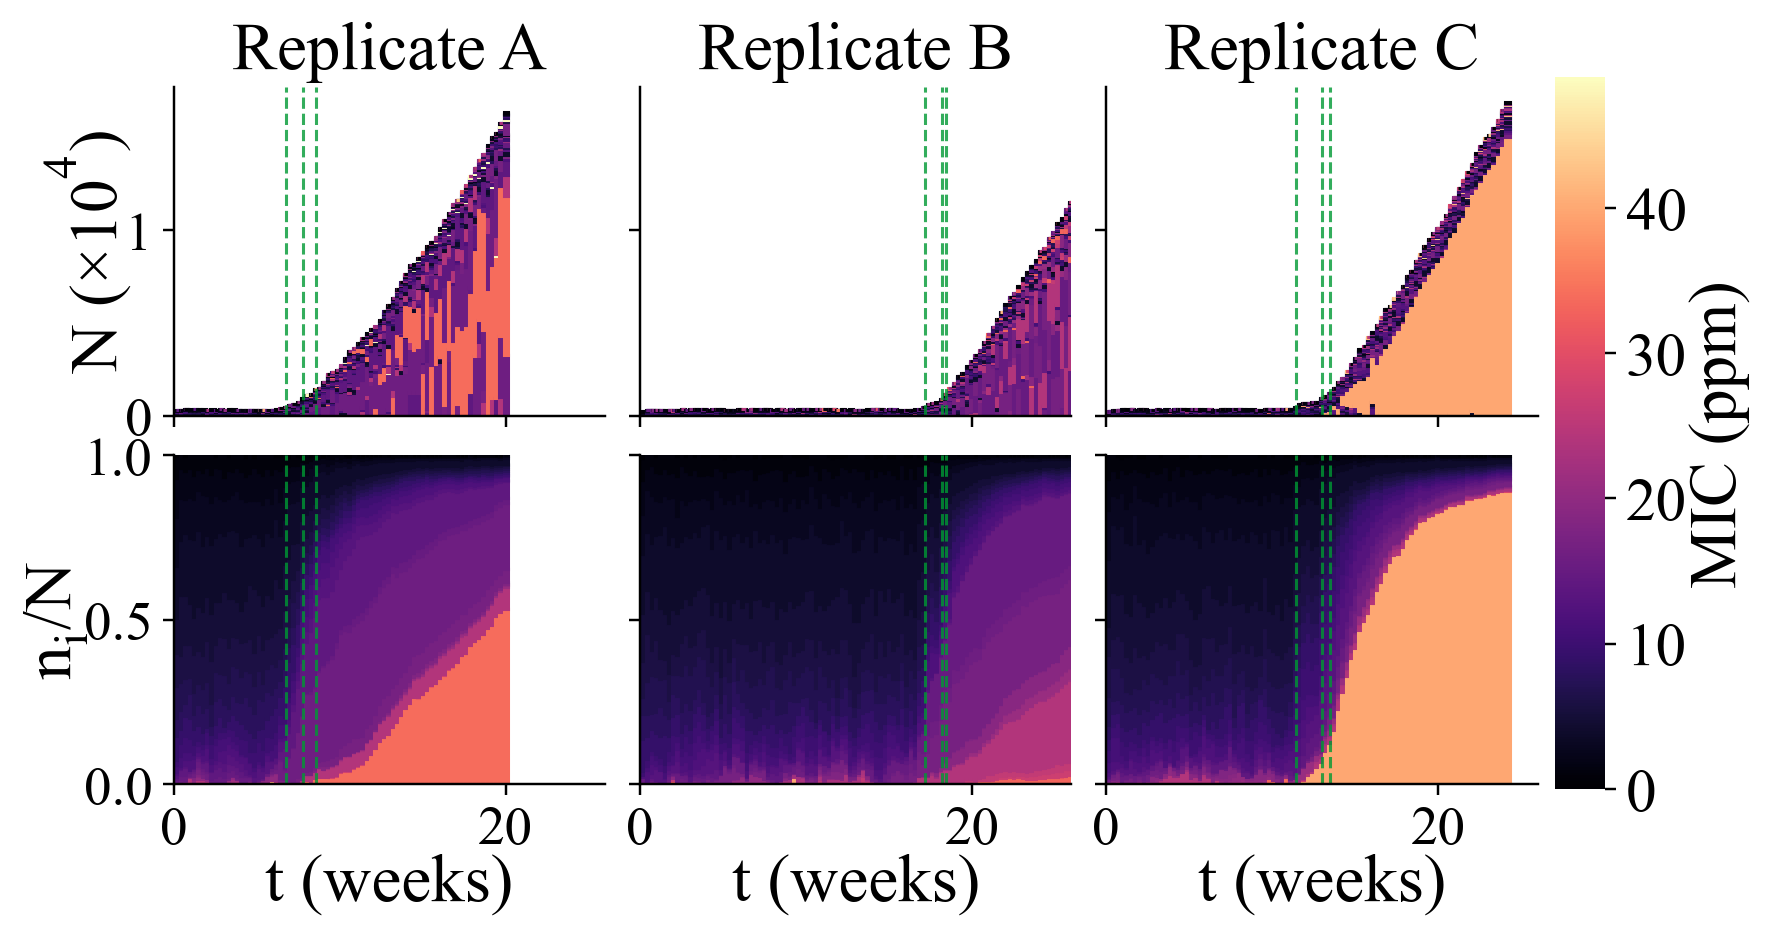

In [22]:
#plot2x3GridOfGenoDistbs_wrt_t(geno_2x3_plot_data_regular_r_mig, N_max=n_max_2x3_16pc,           geno_max=geno_max_2x3_16pc)


In [17]:
def get_avg_plateau_time(event_counters, pc_res, suffix=""):
    '''
    this is used to calculate the avg time it takes for the system to go from 1st microhab biofilm to 2nd microhab
    '''
    
    growth_runs = list(event_counters[event_counters["bf_thickness"] > 0].sort_values(by=["n_replications"], ascending=False)['runID'].values)
    
    times_between_biofilm = []
    
    for runID in growth_runs:
        geno_dict = getGenoDistbDict(runID, pc_res=pc_res, phase_val=phase2_str, event_counters=event_counters, suffix=suffix)
        
        new_mh_times = getNewMicrohabTimes(geno_dict)
        
        if len(new_mh_times) >= 3:
            new_mh_diff = new_mh_times[2] - new_mh_times[1]
        
            times_between_biofilm.append(new_mh_diff)
        
    
    times_between_bf_array = np.array(times_between_biofilm)
    mh_diff_mean = np.mean(times_between_bf_array)
    mh_diff_stDev = np.std(times_between_bf_array)
    mh_diff_std_err = mh_diff_stDev/np.sqrt(times_between_bf_array.size)
    
    print(f"time between microhabs: {mh_diff_mean:.2f} +/- {mh_diff_std_err:.2f}, \tstdDev: {mh_diff_stDev:.2f}")

In [18]:
get_avg_plateau_time(all_event_counters_16pc, 16, suffix="")

time between microhabs: 2.65 +/- 0.20, 	stdDev: 1.17


In [19]:
#get_avg_plateau_time(all_event_counters_16pc_low_r_mig, 16, suffix="-migration_rate-0.1")

time between microhabs: 1.50 +/- 0.09, 	stdDev: 0.71


In [20]:
#get_avg_plateau_time(all_event_counters_14pc, 14)

NameError: name 'all_event_counters_14pc' is not defined

In [ ]:
# plot the exponential gradient vs microhabitat for model diagram
fontsize=42
labelsize=34


fig, ax = plt.subplots(dpi=120)
fig.set_size_inches(8,6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
alpha = 0.01
c_max = 5

x = np.arange(0, 42, 1)
x_cont = np.linspace(0, 41, 1000)

def calc_exp(x, c_max, alpha):
    x_avg = (x[:-1] + x[1:])/2.
    return c_max*np.exp(-alpha*x_avg)

c_grad = calc_exp(x, c_max=c_max, alpha=alpha)
c_grad_cont = calc_exp(x_cont, c_max=c_max, alpha=alpha)

ax.scatter(x[:-1], c_grad, s=140, c='#ff0066')
ax.plot(x[:-1], c_grad, c='#ff0066')

ax.tick_params(axis='both', labelsize=labelsize)
ax.set_xlim(-0.5, 40.5)

ax.set_title("Biocide concentration\nprofile", fontsize=fontsize, linespacing=0.8)
ax.set_ylabel("c$_i$", fontsize=fontsize)
ax.set_xlabel("microhabitat", fontsize=fontsize, labelpad=0)
ax.yaxis.set_major_locator(plt.MaxNLocator(4))
plt.savefig("geno_distb_plots/c_gradient.pdf", bbox_inches='tight', dpi=330)

In [ ]:
# plot some growth curves vs c for several beta values
fig, ax = plt.subplots(dpi=120)
fig.set_size_inches(8,6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


def growth_curve(c, beta):
    cB = c/beta
    return 1. - (6.*cB**2)/(5.+cB**2)

c = np.linspace(0, 5, 1000)

beta_vals = [1., 2.5, 5., 10.]

for b in beta_vals:
    ax.plot(c, growth_curve(c, b), label=f'MIC = {b:.1f}', lw=7)


ax.set_title('Biocide inhibition\ncurve', fontsize=fontsize, linespacing=0.6)
ax.set_xlabel("c", fontsize=fontsize, labelpad=-10)
ax.set_ylabel("$\\phi(c, MIC)$", fontsize=fontsize, labelpad=0)
ax.tick_params(axis='both', labelsize=labelsize)
ax.set_xlim(-0., 5.1)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], fontsize=22, handletextpad=0.3)
plt.savefig("geno_distb_plots/growth_curves.pdf", bbox_inches='tight', dpi=330)
plt.show()

Hi Rosalind, 

Yes, I made the neccessary adjustments that you asked for.  I was a little bit confused by one comment though, you seemed to imply that the units of the MIC weren't ppm, but I'd been labouring under the assumption that they were.  Is there some other unit system they could be?

Also, working through my thesis, I now have a few other quick questions.

1. We discuss using tau-leaping instead of the Monte-Carlo algorithm for the multispecies model because there's a large number of channels due to all the differing species.  However, how do we justify using tau-leaping for the bftt chapter, where all the bacteria are the same species?

2. There's a comment which mentions that the microhabitat method of modelling things neglects certain biological information.  I just wanted to confirm what exactly that is.  I'm assuming things like the spatial structure/arrangement of individual bacteria?

3. Do we have a reasonable justification for why we reduced the migration rate in the multispecies paper?  It's still larger in the multispecies paper than the bftt one, not sure if that's relevant at all.

Best,
Patrick